#SVM como clasificador

##SVM lineal
En *Scikit Learn* pueden encontrarse tres implementaciones distintas del algoritmo Suport Vector Machine:
*   Las clases `sklearn.svm.SVC` y `sklearn.svm.NuSVC` permiten crear modelos SVM de clasificación empleando kernel lineal, polinomial, radial o sigmoide. La diferencia es que `SVC` controla la regularización a través del hiperparámetro `C`, mientras que `NuSVC` lo hace con el número máximo de vectores soporte permitidos.
*  La clase `sklearn.svm.LinearSVC` permite ajustar modelos SVM con kernel lineal. Es similar a SVC cuando el parámetro `kernel='linear'`, pero utiliza un algoritmo más rápido.

Las mismas implementaciones están disponibles para regresión en las clases: `sklearn.svm.SVR`, `sklearn.svm.NuSVR` y `sklearn.svm.LinearSVR`.

Se ajusta primero un modelo SVM con kernel lineal y después uno con kernel radial, y se compara la capacidad de cada uno para clasificar correctamente las observaciones.

In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Datos
# ==============================================================================
datos = pd.read_csv('./SVM.csv')
datos.head(3)

,X1,X2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0


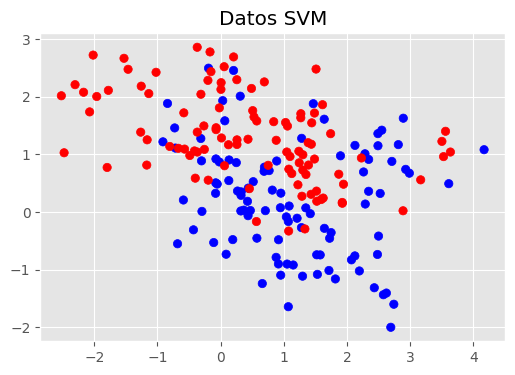

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(datos.X1, datos.X2, c=datos.y);
ax.set_title("Datos SVM");

In [7]:
#from os import X_OK
# División de los datos en train y test
# ==============================================================================
X0 = datos.drop(columns = 'y')
y0 = datos['y']

X_train, X_test, y_train, y_test = train_test_split(
                                        X0,
                                        y0.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [8]:
# Creación del modelo SVM lineal
# ==============================================================================
modelo = SVC(C = 100, kernel = 'linear', random_state=42)
modelo.fit(X_train, y_train)

SVC(C=100, kernel='linear', random_state=42)

Al tratarse de un problema de dos dimensiones, se puede representar las regiones de clasificación.

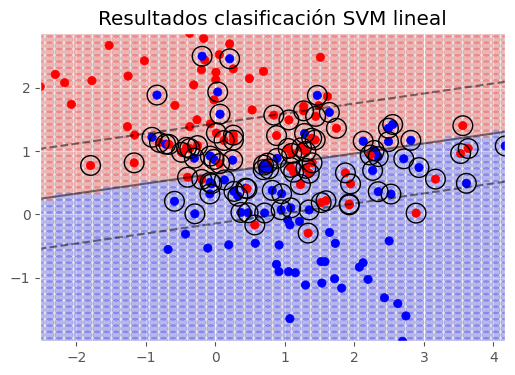

In [9]:
# Representación gráfica de los límites de clasificación
# ==============================================================================
# Grid de valores
x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
Y, X = np.meshgrid(y, x)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Predicción valores grid
pred_grid = modelo.predict(grid)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

# Vectores soporte
ax.scatter(
    modelo.support_vectors_[:, 0],
    modelo.support_vectors_[:, 1],
    s=200, linewidth=1,
    facecolors='none', edgecolors='black'
)

# Hiperplano de separación
ax.contour(
    X,
    Y,
    modelo.decision_function(grid).reshape(X.shape),
    colors = 'k',
    levels = [-1, 0, 1],
    alpha  = 0.5,
    linestyles = ['--', '-', '--']
)

ax.set_title("Resultados clasificación SVM lineal");

Se calcula el porcentaje de aciertos que tiene el modelo al predecir las observaciones de test (accuracy).

In [10]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)
predicciones

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [11]:
# Accuracy de test del modelo
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 72.5%


##SVM radial
Se repite el ajuste del modelo, esta vez empleando un kernel radial y utilizando validación cruzada para identificar el valor óptimo de penalización `C`

- `C` : float, default=1.0
Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C. Debe ser estrictamente positivo.
    
- `gamma` : **Se usa en modelos no lineales**. Define cuánta curvatura queremos en la frontera de decisión:
  - Gamma alta significa más curvatura.
  - Gamma baja significa menos curvatura.

  El parámetro `gamma` define hasta dónde llega la influencia de un único ejemplo de entrenamiento, donde valores bajos significan 'lejos' y valores altos significan 'cerca'. Los valores más bajos de `gamma` dan como resultado modelos con menor precisión, al igual que los valores más altos de `gamma`. Son los valores intermedios de `gamma` los que dan un modelo con buenos límites de decisión. Valores de gamma:
  - `gamma` = 'scale' el valor será 1/(n_características * X.var())
  - `gamma` = 'auto' el valor será 1/n_características
  - `gamma` = float (no negativo)


- Hay más hiperparámetros, pero estos dos son los importantes:
  - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
  - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html



In [12]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 7, 20)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = SVC(kernel= "rbf", gamma='scale'),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 3,
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
12,379.269019,0.825181,0.043594,0.875037,0.017379
10,20.691381,0.812835,0.092814,0.834421,0.043227
11,88.586679,0.806429,0.072225,0.853142,0.038341
14,6951.927962,0.793967,0.024542,0.903221,0.026560
9,4.83293,0.793967,0.110597,0.815670,0.028613


In [13]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo = grid.best_estimator_
C_best = grid.best_params_['C']

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 379.2690190732246} : 0.8251805264383881 accuracy


In [14]:
# Una función para representar los SVM
# ==============================================================================
def plotSVC(title):
  # Grid de valores
  x = np.linspace(np.min(X_train.X1), np.max(X_train.X1), 50)
  y = np.linspace(np.min(X_train.X2), np.max(X_train.X2), 50)
  Y, X = np.meshgrid(y, x)
  grid = np.vstack([X.ravel(), Y.ravel()]).T

  # Predicción valores grid
  pred_grid = modelo.predict(grid)

  fig, ax = plt.subplots(figsize=(6,4))
  ax.scatter(grid[:,0], grid[:,1], c=pred_grid, alpha = 0.2)
  ax.scatter(X_train.X1, X_train.X2, c=y_train, alpha = 1)

  # Vectores soporte
  ax.scatter(
      modelo.support_vectors_[:, 0],
      modelo.support_vectors_[:, 1],
      s=200, linewidth=1,
      facecolors='none', edgecolors='black'
  )

  # Hiperplano de separación
  ax.contour(
      X,
      Y,
      modelo.decision_function(grid).reshape(X.shape),
      colors='k',
      levels=[0],
      alpha=0.5,
      linestyles='-'
  )

  ax.set_title(title);

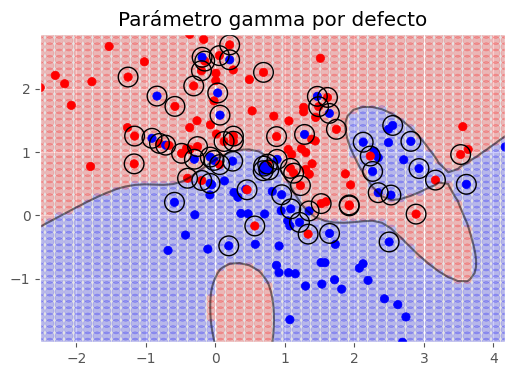

In [15]:
plotSVC("Parámetro gamma por defecto")

Vamos a comprobar el efecto del parámetro gamma. Lo probaremos para varios valores de gamma y fijando el valor de C al encontrado anteriormente.


El accuracy de test es: 82.5% con gamma 0.1

El accuracy de test es: 85.0% con gamma 1

El accuracy de test es: 80.0% con gamma 10

El accuracy de test es: 70.0% con gamma 100


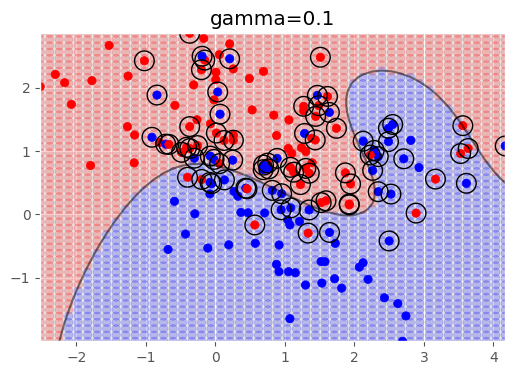

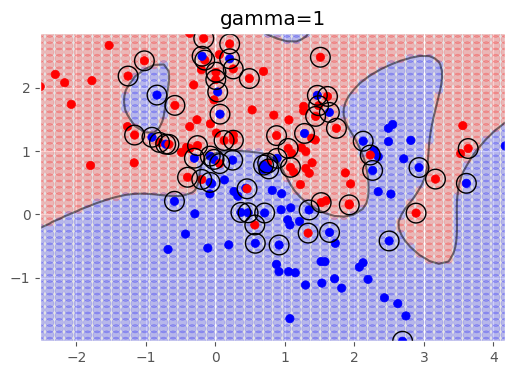

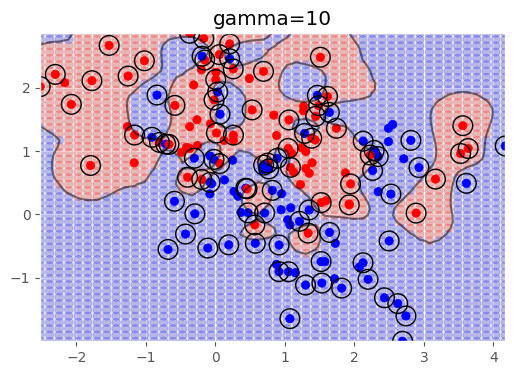

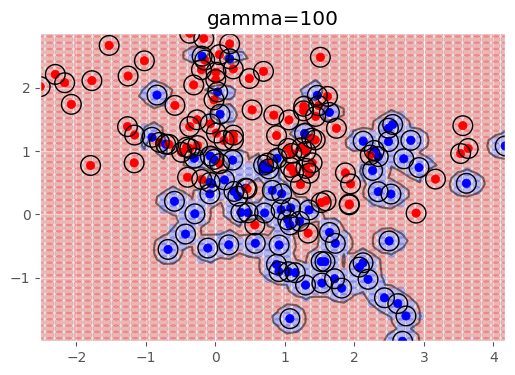

In [16]:
gammas = [0.1, 1, 10, 100]
for gamma in gammas:
   modelo = SVC(kernel='rbf', C=C_best, gamma=gamma).fit(X_train, y_train)
   plotSVC('gamma=' + str(gamma))
   predicciones = modelo.predict(X_test)
   accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
   print("")
   print(f"El accuracy de test es: {100*accuracy}% con gamma " + str(gamma))

El mejor modelo es con un valor de gamma de 1.

In [17]:
modelo = SVC(kernel='rbf', C=C_best, gamma=1).fit(X_train, y_train)

In [18]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X_test)

In [19]:
# Accuracy de test del modelo
# ==============================================================================
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")


El accuracy de test es: 85.0%


In [20]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    predicciones,
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

Predicción,0,1
Real,,
0,17,4
1,2,17


Con un modelo SVM de kernel radial se consigue clasificar correctamente el 85% de las observaciones de test.

In [21]:
# Entregamos el modelo final entrenado con todos los datos
modelo_final = SVC(kernel='rbf', C=C_best, gamma=1).fit(X0, y0)

# SVM como regresor

Primero, se cargan los datos, las entradas van a X, las salidas a y.

In [23]:
# Datos
# ==============================================================================
datos = pd.read_csv('./Student_Marks.csv')
datos.head(3)

,number_courses,time_study,Marks
0,3,4.508,19.202
1,4,0.096,7.734
2,4,3.133,13.811


Queremos buscar una función que en función de las horas diarias de estudio, nos estime la nota media que vamos a sacar.

In [24]:
train, test = train_test_split(datos, test_size=0.2, random_state=42)

# train y test datasets los ordenamos para poder dibujarlo bien
train = train.sort_values('time_study')
test = test.sort_values('time_study')

X_train, X_test = train[['time_study']], test[['time_study']]
y_train, y_test = train['Marks'], test['Marks']

X = datos.iloc[:,1:2].values.astype(float)
y = datos.iloc[:,2:3].values.astype(float)


In [25]:
y_train.describe(include="all")

count    80.000000
mean     23.319450
std      13.583962
min       5.609000
25%      12.633000
50%      19.577000
75%      30.955500
max      53.359000
Name: Marks, dtype: float64

Comprobamos el rango de la variable de salida va de 5.6 a 53.25


##SVM lineal

En primer lugar, definamos nuestra función python para el RMSE

In [26]:
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

En primer lugar, obtenemos el modelo lineal con hiperparámetros por defecto

In [27]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svr_lineal = SVR(kernel="linear")
escalar = StandardScaler()

pipe_regr_lineal = Pipeline([
    ('escalar', escalar),
    ('SVM', svr_lineal)])

np.random.seed(42)
pipe_regr_lineal.fit(X=X_train, y=y_train)
print(f"RMSE of SVR with default hyper-pars: {rmse(y_test, pipe_regr_lineal.predict(X=X_test))}")
print(f"Param C: {pipe_regr_lineal['SVM'].C}")


RMSE of SVR with default hyper-pars: 6.698187721447375
Param C: 1.0


Hacemos una búsqueda por el mejor parámetro C con una GridSearch

In [28]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import KFold


param_grid = {'SVM__C': [0.1, 1, 10, 100]}


inner = KFold(n_splits=3, shuffle=True, random_state=42)

hpo_regr_lineal = GridSearchCV(pipe_regr_lineal,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner,
                        n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr_lineal.fit(X=X_train, y=y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                       ('SVM', SVR(kernel='linear'))]),
             n_jobs=4, param_grid={'SVM__C': [0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error', verbose=1)

Visualicemos:
- Los mejores hiperparámetros y su puntuación (¡inner!).
- La evaluación del modelo (¡outer!) con los datos de test y los mejores hiperparámetros.



In [29]:
print(f"Best params: {hpo_regr_lineal.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_lineal.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_lineal.predict(X=X_test))}")

Best params: {'SVM__C': 100}, best score (inner!): 5.241793050206843
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 4.8317602629431775


Observamos que el mejor valor de C es 100 que está en el límite del espacio de búsqueda. Podemos plantearnos ampliar el espacio de búsqueda y ver si mejoran los resultados.

In [30]:
# Search space
param_grid = {'SVM__C': [0.001, 0.01, 1, 10, 100, 1000, 10000, 50000, 100000]}

hpo_regr_lineal = GridSearchCV(pipe_regr_lineal,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner,
                        n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr_lineal.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                       ('SVM', SVR(kernel='linear'))]),
             n_jobs=4,
             param_grid={'SVM__C': [0.001, 0.01, 1, 10, 100, 1000, 10000, 50000,
                                    100000]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
print(f"Best params: {hpo_regr_lineal.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_lineal.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_lineal.predict(X=X_test))}")

Best params: {'SVM__C': 100000}, best score (inner!): 5.231887932656821
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 4.807185146923307


##SVM Radial

Pasamos ahora a usar un Kernel radial. Y probamos con los parámetros por defecto

In [32]:
svr_radial = SVR() #por defecto es el Kernel radial

pipe_regr_radial_def = Pipeline([
    ('escalar', escalar),
    ('SVM', svr_radial)])

np.random.seed(42)
pipe_regr_radial_def.fit(X=X_train, y=y_train)

print(f"Param C: {pipe_regr_radial_def['SVM'].C}, y gamma: {pipe_regr_radial_def['SVM'].gamma}")
print(f"RMSE of SVR with default hyper-pars: {rmse(y_test, pipe_regr_radial_def.predict(X=X_test))}")



Param C: 1.0, y gamma: scale
RMSE of SVR with default hyper-pars: 9.027599400519653


###Búsqueda de parámetros en Grid

Hacemos una búsqueda Grid para el mejor parámetro

In [33]:
param_grid = {'SVM__C': [0.001, 0.01, 1, 10, 100, 1000, 10000, 100000],
              'SVM__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}


inner = KFold(n_splits=3, shuffle=True, random_state=42)

hpo_regr_radial = GridSearchCV(pipe_regr_radial_def,
                               param_grid,
                               scoring='neg_mean_squared_error',
                               cv=inner,
                               n_jobs=4, verbose=1)

# Train the self-adjusting process
np.random.seed(42)
hpo_regr_radial.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                       ('SVM', SVR())]),
             n_jobs=4,
             param_grid={'SVM__C': [0.001, 0.01, 1, 10, 100, 1000, 10000,
                                    100000],
                         'SVM__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
print(f"Best params: {hpo_regr_radial.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_radial.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_radial.predict(X=X_test))}")

Best params: {'SVM__C': 100000, 'SVM__gamma': 0.01}, best score (inner!): 3.256593936967635
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 2.985953054371936


###Búsqueda de parámetros en Random

Ahora, vamos a utilizar **Randomized Search** en lugar de gridsearch. Sólo se probarán 20 combinaciones de valores de hiperparámetros (budget=20)

In [35]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


budget = 20
hpo_regr_radial = RandomizedSearchCV(pipe_regr_radial_def,
                              param_grid,
                              scoring='neg_mean_squared_error',
                              cv=inner,
                              n_jobs=-1, verbose=1,
                              n_iter=budget
                             )
np.random.seed(42)
hpo_regr_radial.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                             ('SVM', SVR())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'SVM__C': [0.001, 0.01, 1, 10, 100,
                                                   1000, 10000, 100000],
                                        'SVM__gamma': [1e-05, 0.0001, 0.001,
                                                       0.01, 0.1, 1]},
                   scoring='neg_mean_squared_error', verbose=1)

In [36]:
print(f"Best params: {hpo_regr_radial.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_radial.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_radial.predict(X=X_test))}")

Best params: {'SVM__gamma': 0.01, 'SVM__C': 100000}, best score (inner!): 3.256593936967635
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 2.985953054371936


Hemos obtenido los mismos resultados, pero explorando menos posibilidades que con grid-search.

Para **Randomized Search**, podemos definir el espacio de búsqueda con distribuciones estadísticas, en lugar de utilizar valores particulares como hacíamos antes. A continuación puedes ver cómo utilizar una distribución `loguniform`.


In [40]:
from scipy.stats import loguniform


# Search space
param_grid = {'SVM__C': loguniform(1e-1, 1e4),
              'SVM__gamma': loguniform(1e-5, 1e1)}

hpo_regr_radial = RandomizedSearchCV(pipe_regr_radial_def,
                            param_grid,
                            scoring='neg_mean_squared_error',
                            cv=inner,
                            n_jobs=4, verbose=0,
                            n_iter=budget
                        )
np.random.seed(42)
hpo_regr_radial.fit(X=X_train, y=y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                             ('SVM', SVR())]),
                   n_iter=20, n_jobs=4,
                   param_distributions={'SVM__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024024AED0A0>,
                                        'SVM__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024024AE8F70>},
                   scoring='neg_mean_squared_error')

In [41]:
print(f"Best params: {hpo_regr_radial.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_radial.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_radial.predict(X=X_test))}")

Best params: {'SVM__C': 101.29197956845728, 'SVM__gamma': 0.1771884735480681}, best score (inner!): 3.3023439239362506
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 2.9865162714110642


##Comparativa entre lineal y radial

Obtenemos y dibujamos las estimaciones para tres casos:


*   Estimador con kernel lineal
*   Estimador con kernel radial óptimo
*   Estimador con kernel radial y parámetro gamma bajo
*   Estimador con kernel radial y parámetro gamma alto



Text(0, 0.5, 'Puntuación')

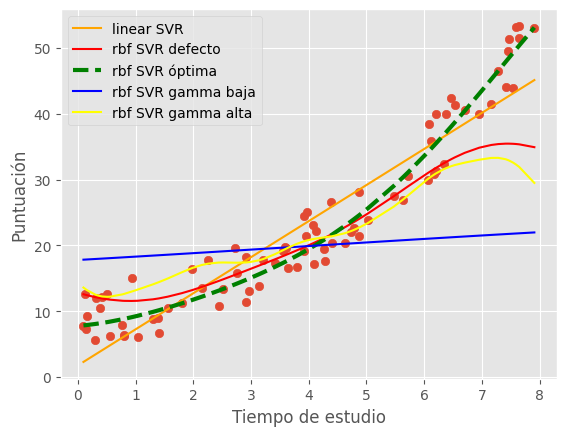

In [42]:
from matplotlib import pyplot as plt

bestC = hpo_regr_radial.best_params_['SVM__C']

#Usamos un modelo con un gamma baja
pipe_regr_radial_gamma_baja = Pipeline([
    ('escalar', escalar),
    ('SVM', SVR(gamma=0.01))])

#Usamos un modelo con un gamma alta
pipe_regr_radial_gamma_alta = Pipeline([
    ('escalar', escalar),
    ('SVM', SVR(gamma=10))])

np.random.seed(42)
pipe_regr_radial_gamma_baja.fit(X=X_train, y=y_train)
pipe_regr_radial_gamma_alta.fit(X=X_train, y=y_train)

#### Predicciones ####
train['linear_svr_pred'] = hpo_regr_lineal.predict(X_train)
train['rbf_svr_pred_def'] = pipe_regr_radial_def.predict(X_train)
train['rbf_svr_pred_opt'] = hpo_regr_radial.predict(X_train)
train['rbf_svr_pred_baja'] = pipe_regr_radial_gamma_baja.predict(X_train)
train['rbf_svr_pred_alta'] = pipe_regr_radial_gamma_alta.predict(X_train)

#### Visualización ####
plt.scatter(train['time_study'], train['Marks'])
plt.plot(train['time_study'], train['linear_svr_pred'], color = 'orange', label = 'linear SVR')
plt.plot(train['time_study'], train['rbf_svr_pred_def'], color = 'red',  label = 'rbf SVR defecto')
plt.plot(train['time_study'], train['rbf_svr_pred_opt'], color = 'green', linestyle='--', linewidth=3, label = 'rbf SVR óptima')
plt.plot(train['time_study'], train['rbf_svr_pred_baja'], color = 'blue', label = 'rbf SVR gamma baja')
plt.plot(train['time_study'], train['rbf_svr_pred_alta'], color = 'yellow', label = 'rbf SVR gamma alta')
plt.legend()
plt.xlabel('Tiempo de estudio')
plt.ylabel('Puntuación')

Se puede observar en verde como el estimador radial óptimo es el mejor.

##Obtención de los dos modelos para el cliente

Por último, necesitamos un modelo final, podemos obtenerlo entrenando `hpo_regr_radial` a todos los datos disponibles.

In [43]:
np.random.seed(42)

regrFinal_radial = hpo_regr_radial.fit(X,y)

##Bayesian Optimization (plus)

Para ello se utilizará scikit-optimize (`skopt`): https://scikit-optimize.github.io. **Holdout** para la evaluación del modelo y **3-fold crossvalidation** para el ajuste de hiperparámetros (con **Model Based Optimization** ).


In [44]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

^C


  Cloning https://github.com/scikit-optimize/scikit-optimize.git to c:\users\189lu\appdata\local\temp\pip-req-build-4fafd8l5
  Resolved https://github.com/scikit-optimize/scikit-optimize.git to commit a2369ddbc332d16d8ff173b12404b03fea472492
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/scikit-optimize/scikit-optimize.git 'C:\Users\189lu\AppData\Local\Temp\pip-req-build-4fafd8l5'


In [45]:
from skopt import BayesSearchCV
from skopt.space import Real

# Search space
param_grid = {'SVM__C': Real(1e-1, 1e4, prior="log-uniform"),
              'SVM__gamma': Real(1e-4, 1e0, prior="log-uniform")}

hpo_regr_radial = BayesSearchCV(pipe_regr_radial_def,
                        param_grid,
                        scoring='neg_mean_squared_error',
                        cv=inner,
                        n_jobs=4, verbose=0,
                        n_iter=budget
                        )
np.random.seed(42)
hpo_regr_radial.fit(X=X_train, y=y_train)

BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('escalar', StandardScaler()),
                                        ('SVM', SVR())]),
              n_iter=20, n_jobs=4, scoring='neg_mean_squared_error',
              search_spaces={'SVM__C': Real(low=0.1, high=10000.0, prior='log-uniform', transform='normalize'),
                             'SVM__gamma': Real(low=0.0001, high=1.0, prior='log-uniform', transform='normalize')})

In [46]:
print(f"Best params: {hpo_regr_radial.best_params_}, best score (inner!): {np.sqrt(-hpo_regr_radial.best_score_)}")
# Now, the performance of regr is computed on the test partition
print(f"RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): {rmse(y_test, hpo_regr_radial.predict(X=X_test))}")

Best params: OrderedDict([('SVM__C', 1291.2708290194898), ('SVM__gamma', 0.05633977814776661)]), best score (inner!): 3.2472435555308157
RMSE (outer!) of SVR with hyper-parameter tuning (grid-search): 2.9834425243797473


Podemos comprobar si la optimización ha convergido

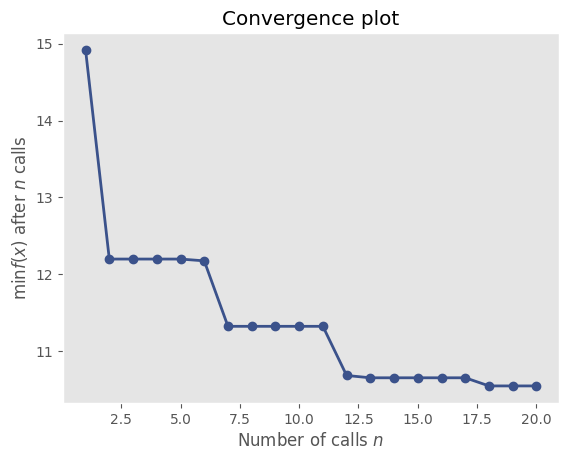

In [47]:
from skopt.plots import plot_convergence

_ = plot_convergence(hpo_regr_radial.optimizer_results_[0])
plt.show()

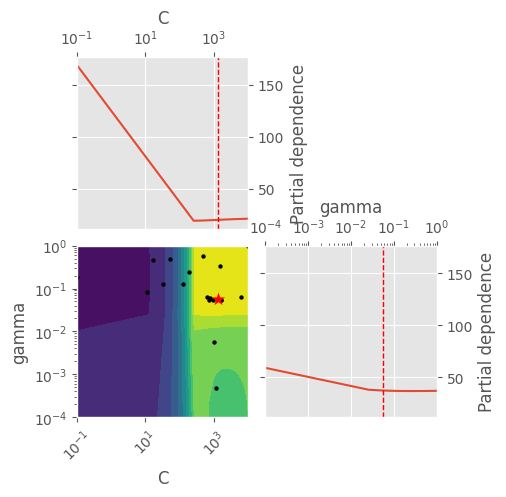

In [48]:
from skopt.plots import plot_objective

_ = plot_objective(hpo_regr_radial.optimizer_results_[0],
                   dimensions=['C', 'gamma'],
                   n_minimum_search=int(1e8))
plt.show()